<a href="https://colab.research.google.com/github/RedBatProject/advanced-works/blob/main/mask_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from IPython.display import clear_output


# Create Data

In [10]:
!git clone https://github.com/Dadmatech/Nevise-Dataset.git
clear_output()

--2024-06-01 18:54:11--  https://github.com/Dadmatech/Nevise-Dataset/blob/main/nevise-news-title-539/nevise-news-title-539_wrongs.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘nevise-news-title-539_wrongs.txt’

nevise-news-title-5     [  <=>               ] 557.91K  2.04MB/s    in 0.3s    

2024-06-01 18:54:12 (2.04 MB/s) - ‘nevise-news-title-539_wrongs.txt’ saved [571298]



# First CER/WER

In [16]:
!pip install evaluate
!pip install jiwer
clear_output()
import evaluate

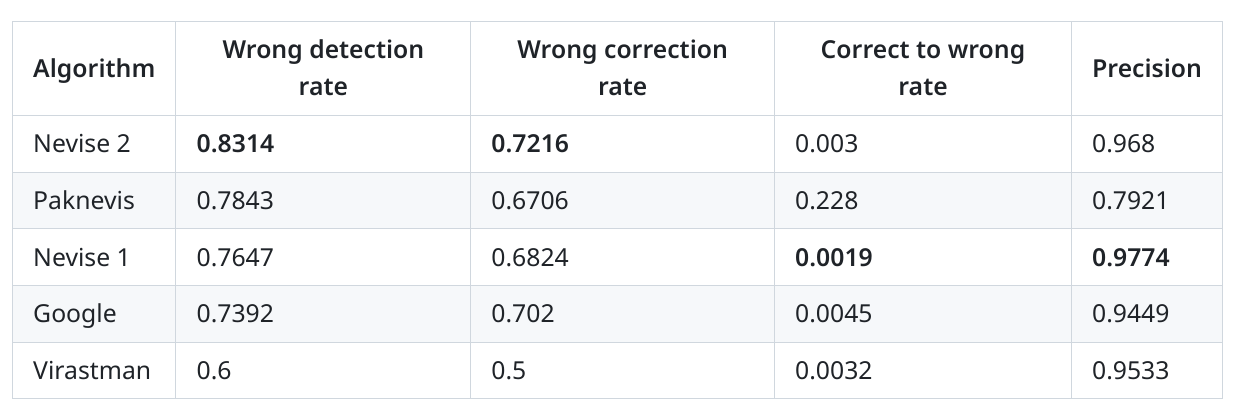

https://github.com/Dadmatech/Nevise?tab=readme-ov-file

https://github.com/Dadmatech/Nevise-Dataset/tree/main/nevise-news-title-539

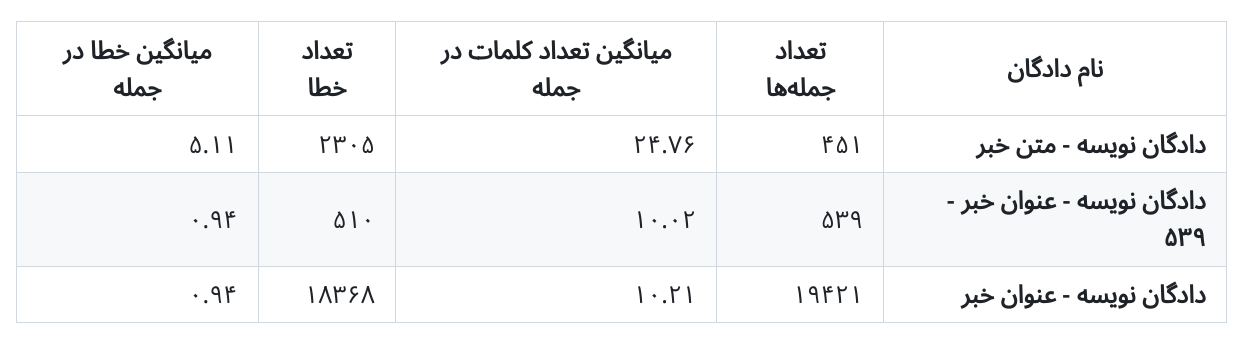

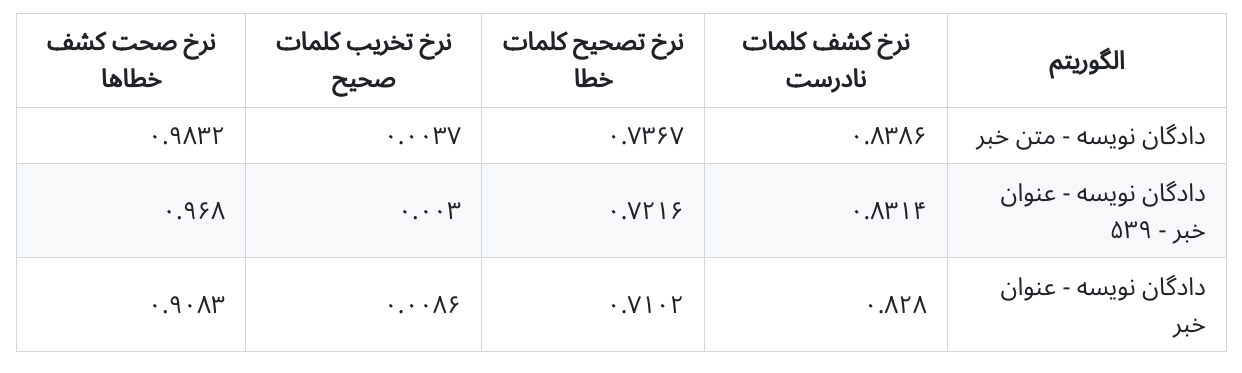

In [19]:
# Define your references (ground truth) and predictions
references = open('/content/Nevise-Dataset/nevise-news-title-539/nevise-news-title-539_corrects.txt','r').readlines()
predictions = open('/content/Nevise-Dataset/nevise-news-title-539/nevise-news-title-539_wrongs.txt','r').readlines()

In [20]:
# Load the WER and CER metrics from the evaluate package
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [21]:
# Compute WER
wer_result = wer_metric.compute(predictions=predictions, references=references)
print("WER:", wer_result)

# Compute CER
cer_result = cer_metric.compute(predictions=predictions, references=references)
print("CER:", cer_result)

WER: 0.09615384615384616
CER: 0.022517467327951346


## How to find wrong words?

Lets just find the wrong words from references! huh?

In [27]:
predictions2,references2 = predictions,references

In [44]:
len(references)

539

In [30]:
predictions,references = [],[]
for i,j in zip(predictions2,references2):
    predictions.append(i.replace('\n',''))
    references.append(j.replace('\n',''))

In [50]:
wrong_words=[]
for i,j in zip(predictions,references):
    s1 = len(wrong_words)
    for i1 in i.split(' '):
        if i1 not in set(j.split(' ')) and len(i1)!=0:
            # print(i1,'|',j)
            # print(i1)

            wrong_words.append(i1)
    # if len(wrong_words) == s1:
        # print(i)
        # print(j)
len(wrong_words)

512

In [53]:
wrong_words[0:10]

['مجیید',
 'ممعاون',
 'اک',
 'برایی',
 'اطز',
 'براب',
 'هزران',
 'یم',
 'کارگزران',
 'رابر']

## can we find these errors using fabert?

In [308]:
wrongs = []
for text in predictions[:10]:
    miniwrong = []
    c = text.split(' ')[0:-1]
    for knd,k in enumerate(c):
        sentence = ' '.join([c[i] if i!= knd  else '[MASK]' for i in range(len(c))])
        # print(sentence)
        inputs = tokenizer(sentence, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
        h = torch.softmax(outputs.logits[0], dim=1).max(1)[0][1:-1]
        miniwrong.append(h.sum().item()/h.shape[0])
        # break
    wrongs.append(c[torch.tensor(miniwrong).max(0)[1].item()])
    # break


In [310]:
c[torch.tensor(miniwrong).max(0)[1].item()]

'و'

In [309]:
torch.tensor(miniwrong)

tensor([0.8805, 0.8723, 0.8168, 0.8174, 0.8332, 0.9013, 0.8643, 0.8570])

In [301]:
c[9]

'هستند'

# some trick?

In [419]:
wrongs = []
for text in predictions[1:2]:
    miniwrong = []
    c = text.split(' ')[0:-1]
    for knd,k in enumerate(c):
        sentence = ' '.join([c[i] if i!= knd  else '[MASK]' for i in range(len(c))])
        print(sentence)
    #     inputs = tokenizer(sentence, return_tensors='pt')
    #     with torch.no_grad():
    #         outputs = model(**inputs)
    #     h = torch.softmax(outputs.logits[0], dim=1).max(1)[0][1:-1]
    #     miniwrong.append(h.sum().item()/h.shape[0])
    #     # break
    # wrongs.append(c[torch.tensor(miniwrong).max(0)[1].item()])
    # # break


[MASK] نازی ممعاون امور دریایی سازمان بنادر شد
علی [MASK] ممعاون امور دریایی سازمان بنادر شد
علی نازی [MASK] امور دریایی سازمان بنادر شد
علی نازی ممعاون [MASK] دریایی سازمان بنادر شد
علی نازی ممعاون امور [MASK] سازمان بنادر شد
علی نازی ممعاون امور دریایی [MASK] بنادر شد
علی نازی ممعاون امور دریایی سازمان [MASK] شد
علی نازی ممعاون امور دریایی سازمان بنادر [MASK]


In [440]:
s = ['[MASK] نازی ممعاون امور دریایی سازمان بنادر شد'
,'علی [MASK] ممعاون امور دریایی سازمان بنادر شد'
,'علی نازی [MASK] امور دریایی سازمان بنادر شد'
,'علی نازی ممعاون [MASK] دریایی سازمان بنادر شد'
,'علی نازی ممعاون امور [MASK] سازمان بنادر شد'
,'علی نازی ممعاون امور دریایی [MASK] بنادر شد'
,'علی نازی ممعاون امور دریایی سازمان [MASK] شد'
,'علی نازی ممعاون امور دریایی سازمان بنادر [MASK]',
     'علی نازی ممعاون امور دریایی سازمان بنادر شد']

In [439]:
" ".join([i for i in c])

'علی نازی ممعاون امور دریایی سازمان بنادر شد'

In [488]:
tokenizer('معاون', return_tensors='pt')

{'input_ids': tensor([[ 101, 5879,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [516]:
sentence = s[4]
# sentence = 'ممعاون'
# sentence = 'معاون'

print(sentence)


inputs = tokenizer(sentence, return_tensors='pt')
print(inputs['input_ids'])
masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
print(masked_index)
# inputs['input_ids'][0][4] = 103
# Get predictions for the masked token
with torch.no_grad():
    outputs = model(**inputs)
h = torch.softmax(outputs.logits[0], dim=1).max(1)[0]
print(h.mean())
try:
    masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    predicted_token_ids = torch.topk(outputs.logits[0, masked_index], k=5).indices
    predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]
    print(predicted_tokens)
except Exception as e:
    print('oops!',e)
for i,j in zip(inputs['input_ids'][0].tolist(),h.tolist()):
    print(tokenizer.decode(i),'|',i,'|',j)

علی نازی ممعاون امور [MASK] سازمان بنادر شد
tensor([[  101,  2520, 13197,  3018, 44215,  3908,   103,  3057, 22258,  2369,
           102]])
tensor([6])
tensor(0.6509)
['دریایی', 'بین\u200cالملل', 'بنادر', 'اقتصادی', 'استان\u200cهای']
[CLS] | 101 | 0.0576997846364975
علی | 2520 | 0.9998499155044556
نازی | 13197 | 0.06039368733763695
مم | 3018 | 0.9925997257232666
##عاون | 44215 | 0.6452685594558716
امور | 3908 | 0.9996824264526367
[MASK] | 103 | 0.3564378023147583
سازمان | 3057 | 0.9999278783798218
بنادر | 22258 | 0.9915892481803894
شد | 2369 | 0.999049961566925
[SEP] | 102 | 0.05770185589790344


In [506]:
torch.softmax(outputs.logits[0], dim=1)[3].max()

tensor(0.6968)

In [482]:
inputs['input_ids'][0][2]

tensor(103)

In [ ]:
[CLS] | 0.9998418092727661
علی | 0.08372770249843597
نازی | 0.9248677492141724
مم | 0.9374632835388184
##عاون | 0.9996863603591919
امور | 0.9976012110710144
دریایی | 0.9999403953552246
سازمان | 0.9993409514427185
بنادر | 0.9992746710777283

In [459]:
h.tolist()

[0.9998382329940796,
 0.17141956090927124,
 0.9940511584281921,
 0.9226423501968384,
 0.6468421220779419,
 0.9981058835983276,
 0.9999297857284546,
 0.9978196620941162,
 0.9992856383323669]

In [ ]:
8824

In [418]:
c

['علی', 'نازی', 'ممعاون', 'امور', 'دریایی', 'سازمان', 'بنادر', 'شد']

In [416]:
wrongs

['امور']

In [336]:
wrong_words[0:10]

['مجیید',
 'ممعاون',
 'اک',
 'برایی',
 'اطز',
 'براب',
 'هزران',
 'یم',
 'کارگزران',
 'رابر']

In [407]:
c = predictions[0].split(' ')[:-1]
u =[]
for knd,k in enumerate(c):
    sentence = ' '.join([c[i] if i!= knd  else '[MASK]' for i in range(len(c))])
    u.append(sentence)
u.append(predictions[0][0:-1])
u

['[MASK] تیم ما را بریدند تعدادی بچه کنار مجیید هستند',
 'سر [MASK] ما را بریدند تعدادی بچه کنار مجیید هستند',
 'سر تیم [MASK] را بریدند تعدادی بچه کنار مجیید هستند',
 'سر تیم ما [MASK] بریدند تعدادی بچه کنار مجیید هستند',
 'سر تیم ما را [MASK] تعدادی بچه کنار مجیید هستند',
 'سر تیم ما را بریدند [MASK] بچه کنار مجیید هستند',
 'سر تیم ما را بریدند تعدادی [MASK] کنار مجیید هستند',
 'سر تیم ما را بریدند تعدادی بچه [MASK] مجیید هستند',
 'سر تیم ما را بریدند تعدادی بچه کنار [MASK] هستند',
 'سر تیم ما را بریدند تعدادی بچه کنار مجیید [MASK]',
 'سر تیم ما را بریدند تعدادی بچه کنار مجیید هستند']

In [408]:
inputs = tokenizer(u,padding=True ,return_tensors='pt')
ids,mask = inputs['input_ids'],inputs['attention_mask']

In [409]:
with torch.no_grad():
    outputs = model(**inputs)

In [410]:
outputs.logits.shape

torch.Size([11, 13, 50000])

In [411]:
torch.softmax(outputs.logits, dim=0).shape

torch.Size([11, 13, 50000])

In [412]:
j = torch.softmax(outputs.logits, dim=1).max(2)[0].mean(1)

In [413]:
(j - j[-1]).min(0)

torch.return_types.min(
values=tensor(-0.1527),
indices=tensor(6))

In [ ]:
c[torch.tensor(miniwrong).max(0)[1].item()]

'و'

In [ ]:
torch.tensor(miniwrong)

tensor([0.8805, 0.8723, 0.8168, 0.8174, 0.8332, 0.9013, 0.8643, 0.8570])

In [ ]:
c[9]

'هستند'

# How to use SomethingBert

In [63]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
model = AutoModelForMaskedLM.from_pretrained("sbunlp/fabert")
# Set the model to evaluation mode
model.eval()




In [61]:
text=predictions[0]
# text = 'سر تیم ما را بریدند تعدادی بچه کنار [MASK] هستند '

'سر تیم ما را بریدند تعدادی بچه کنار مجیید هستند '

In [435]:
# Prepare the input sentence
sentence = "سلام خوبی [MASK]"
sentence = "سلام [MASK] تو"
# sentence = "[MASK] خوبی تو"
sentence = "سلام خوببی تو"
sentence = s[7]
print(sentence)


inputs = tokenizer(sentence, return_tensors='pt')
masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
print(masked_index)
# Get predictions for the masked token
with torch.no_grad():
    outputs = model(**inputs)
h = torch.softmax(outputs.logits[0], dim=1).max(1)[0][1:-1]
print(h.sum()/h.shape[0])
try:
    masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    predicted_token_ids = torch.topk(outputs.logits[0, masked_index], k=5).indices
    predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]
    print(predicted_tokens)
except Exception as e:
    print('oops!',e)

علی نازی ممعاون امور دریایی سازمان بنادر [MASK]
tensor([9])
tensor(0.7667)
['کشور', 'ایران', 'دریانوردی', ':', '.']


4

In [263]:
outputs.logits[0].shape

torch.Size([6, 50000])

In [264]:
torch.softmax(outputs.logits[0], dim=1)

tensor([[9.0652e-10, 3.9835e-09, 7.2343e-08,  ..., 5.0859e-08, 1.4277e-07,
         7.3295e-08],
        [6.1368e-13, 1.1098e-15, 2.6278e-15,  ..., 1.1647e-13, 1.4463e-12,
         1.5846e-12],
        [7.6186e-14, 1.1514e-12, 5.0212e-12,  ..., 1.1177e-10, 3.7163e-10,
         1.3490e-09],
        [9.2100e-12, 7.4531e-12, 3.3098e-12,  ..., 2.8678e-11, 1.1384e-09,
         2.0069e-09],
        [3.5645e-13, 3.4938e-14, 5.1919e-13,  ..., 2.3878e-11, 6.6348e-10,
         8.5343e-11],
        [9.0649e-10, 3.9834e-09, 7.2343e-08,  ..., 5.0859e-08, 1.4277e-07,
         7.3297e-08]])

In [265]:
torch.softmax(outputs.logits[0], dim=1).max(1)

torch.return_types.max(
values=tensor([0.0820, 0.9999, 0.9967, 0.9906, 0.9813, 0.0820]),
indices=tensor([14369,  2872, 14369,  1312,  2333, 14369]))

In [ ]:
2312

In [266]:
tokenizer.decode(torch.tensor([1312]))

'##ی'

In [ ]:
torch.softmax(outputs.logits[0], dim=1).max(1)[0][1:-1].sum()

In [424]:
try:
    masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    predicted_token_ids = torch.topk(outputs.logits[0, masked_index], k=5).indices
    predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]
    print(predicted_tokens)
except Exception as e:
    print('oops!',e)

['محمد', 'عباس', 'دکتر', 'مهندس', 'سردار']


In [169]:
outputs.logits[0]

tensor([[ -8.6099, -11.2838,  -7.7637,  ...,  -2.2969,   0.0743,  -0.6428],
        [ -7.7676,  -9.9415,  -7.6783,  ...,  -1.1091,   0.8240,  -0.9522],
        [ -0.5938,  -2.4473,  -4.1071,  ...,   1.7444,   7.4153,   8.7125],
        [ -0.1043,  -3.4304,   0.4388,  ...,   4.6066,   7.3673,   5.9113],
        [ -8.6098, -11.2838,  -7.7637,  ...,  -2.2968,   0.0744,  -0.6427]])

In [166]:
torch.softmax(outputs.logits[0], dim=0).max(1)[0]

tensor([4.9590e-01, 1.0000e+00, 1.2470e-07, 5.1619e-09, 4.9590e-01])

In [170]:
masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]


['به', 'از', 'تو', 'برای', 'فدای']

In [115]:
inputs.input_ids

tensor([[  101,  2421,  3082,  2418,  2311, 31544,  6081,  4292,  3081,   103,
          2713,   117,   102]])

In [116]:
tokenizer.mask_token_id

103

In [130]:
masked_index

tensor([9])

In [118]:
# Get the predicted token IDs for the masked position
predicted_token_ids = torch.topk(outputs.logits[0, masked_index], k=5).indices


In [119]:
inputs.input_ids

tensor([[  101,  2421,  3082,  2418,  2311, 31544,  6081,  4292,  3081,   103,
          2713,   117,   102]])

In [120]:
outputs.logits[0][2][3082],outputs.logits[0][2].max()


(tensor(26.4341), tensor(26.4341))

In [129]:
outputs.logits[0][3][3082],outputs.logits[0][2].max()


(tensor(-11.8125), tensor(26.4341))

In [137]:
torch.softmax(outputs.logits[0], dim=0).max(1)[0][1:-1].sum()

tensor(3.0564)

In [112]:
predicted_token_ids

tensor([], size=(0, 5), dtype=torch.int64)

In [89]:

predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]


In [90]:
predicted_tokens

['من', 'ما', 'هم', 'زمین', 'آنها']

# Using fabert

In [54]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="sbunlp/fabert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/552k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [62]:
tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
model = AutoModelForMaskedLM.from_pretrained("sbunlp/fabert")

In [56]:
text=predictions[0]
text

'سر تیم ما را بریدند تعدادی بچه کنار مجیید هستند '

In [58]:
text = 'سر تیم ما را بریدند تعدادی بچه کنار [MASK] هستند '

In [59]:
pipe(text,top_k=1)

[{'score': 0.09213720262050629,
  'token': 2323,
  'token_str': 'هم',
  'sequence': 'سر تیم ما را بریدند تعدادی بچه کنار هم هستند'}]

In [ ]:
reference = """
زندگی هر روز فرصت‌های جدیدی برای یادگیری و پیشرفت به ما می‌دهد. وقتی به دنیای پیرامونمان نگاه می‌کنیم، می‌توانیم از تجربیات خود و دیگران درس بگیریم. گاهی اوقات چالش‌ها و مشکلاتی که با آنها مواجه می‌شویم، می‌توانند به ما نشان دهند که چقدر قوی و مقاوم هستیم. در این مسیر، دوستان و خانواده نقش بسیار مهمی دارند. آنها می‌توانند با حمایت و تشویق‌هایشان ما را به جلو هدایت کنند.

یکی از مهم‌ترین نکات در زندگی این است که همیشه با خودمان صادق باشیم. وقتی با خودمان صادق باشیم، می‌توانیم بهتر تصمیم بگیریم و به اهدافمان نزدیک‌تر شویم. همچنین باید یاد بگیریم که از اشتباهاتمان درس بگیریم. هر اشتباه یک فرصت برای یادگیری است و می‌تواند به ما کمک کند تا در آینده بهتر عمل کنیم.

خواندن کتاب، سفر کردن و گفتگو با افراد مختلف می‌تواند دید ما را نسبت به جهان گسترش دهد. هر کدام از این فعالیت‌ها می‌تواند به ما کمک کند تا چیزهای جدیدی یاد بگیریم و درک بهتری از زندگی پیدا کنیم. در نهایت، مهم‌ترین چیز این است که همیشه با امید و انگیزه به زندگی نگاه کنیم و هرگز دست از تلاش برنداریم.
"""

wrong = """
زندگی هر روز فرست‌های جدیدی برای یاد گیری و پیشرفت به ما میدهد. وقتی به دنیای پیرامونمان نگاه میکنیم، میتوانیم از تجریبات خود و دیگران درس بگیریم. گاهی اوقات چالش‌ها و مشکلاتی که با آنها مواجه میشویم، میتوانند به ما نشان دهند که چقدر قوی و مقاوم هستیم. در این مسیر، دوستان و خانوده نقش بسیار مهمی دارند. انها میتوانند با حمایت و تشویق‌هایشان ما را به جلو هدایت کنند.

یکی از مهمترین نکات در زندگی این است که همیشه با خودمان صادق باشیم. وقتی با خودمان صادق باشیم، میتوانیم بهتر تصمیم بگیریم و به اهدافمان نزدیک‌تر شویم. همچنین باید یاد بگیریم که از اشتباهاتمان درس بگیریم. هر اشتباه یک فرصت برای یاد گیری است و میتواند به ما کمک کند تا در اینده بهتر عمل کنیم.

خواندن کتاب، سفر کردن و گفتگو با افراد مختلف میتواند دید ما را نسبت به جهان گسترش دهد. هر کدام از این فعالیت‌ها میتواند به ما کمک کند تا چیزهای جدیدی یاد بگیریم و درک بهتری از زندگی پیدا کنیم. در نهایت، مهمترین چیز این است که همیشه با امید و انگیزه به زندگی نگاه کنیم و هر گز دست از تلاش برنداریم.
"""



In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert"')
# model = AutoModelForMaskedLM.from_pretrained("sbunlp/fabert")'

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
# model = AutoModelForMaskedLM.from_pretrained("sbunlp/fabert")
# Tokenize input
sentence = "This is a sample sentence."
inputs = tokenizer(sentence, return_tensors='pt')

# Get hidden states from the model
with torch.no_grad():
    outputs = model(**inputs)

# The last hidden state of the [CLS] token
cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()

print(cls_embedding)


tensor([-1.9931e-01, -2.1006e-01, -1.9499e-01, -3.3238e-01, -5.2126e-01,
        -3.7337e-01,  1.5419e-01,  4.0006e-01,  3.5362e-02, -1.5012e-01,
        -3.5267e-01, -2.2861e-01, -9.4948e-02,  1.0328e-01,  5.1352e-01,
        -9.0901e-02,  2.3864e-01,  4.8223e-01,  3.1379e-01, -4.0566e-01,
         9.8627e-02, -8.8768e-02, -2.7461e-01, -5.0871e-01,  2.0913e-01,
        -3.0627e-01, -4.2953e-02, -4.1310e-01, -4.0709e-02,  8.0826e-02,
        -6.0292e-02,  3.5720e-01, -3.4175e-01, -1.4824e-01,  3.9080e-01,
        -1.3152e-01,  3.6742e-01, -9.1257e-03,  4.3404e-01,  1.4182e-01,
        -2.6785e-01, -8.7464e-02,  2.6639e-01,  5.4087e-02, -5.5894e-02,
        -5.7430e-01, -2.8187e+00, -3.4312e-01, -2.7937e-01, -3.0941e-01,
        -8.8544e-02, -2.2791e-01,  4.0630e-01,  5.0902e-01, -2.2796e-01,
         3.7731e-01, -2.9018e-01,  3.1223e-01,  1.9454e-01, -1.0551e-01,
         1.5180e-01, -6.6327e-02, -5.1237e-02, -1.4962e-01, -1.7307e-01,
         6.6952e-01, -1.2911e-01,  3.7059e-01, -3.5

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# Load pre-trained model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("sbunlp/fabert")
model = AutoModelForMaskedLM.from_pretrained("sbunlp/fabert")
# Set the model to evaluation mode
model.eval()

# Prepare the input sentence
sentence = "سلام بر تو [MASK] من."
inputs = tokenizer(sentence, return_tensors='pt')

# Get predictions for the masked token
with torch.no_grad():
    outputs = model(**inputs)




In [ ]:
# Get the index of the masked token
masked_index = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

# masked_index = 1

In [ ]:
# masked_index = torch.tensor(0).unsqueeze(0)
masked_index

tensor([4])

In [ ]:
# Get the predicted token IDs for the masked position
predicted_token_ids = torch.topk(outputs.logits[0, masked_index], k=5).indices


In [ ]:

# Convert token IDs to tokens
# predicted_tokens = [tokenizer.decode(token_id) for token_id in predicted_token_ids[0]]

predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]


In [ ]:
# predicted_tokens = [''.join(tok for tok in tokenizer.decode(token_id).split(' ')) for token_id in predicted_token_ids[0]]


In [ ]:
predicted_tokens

['آقای', 'مولای', 'عشق', 'حسین', 'عزیز']